In [ ]:
# 코랩 사용 시 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ROOT_PATH 확인 
import os

if os.getcwd() == '/content' :
  # 구글 드라이브 사용 시 
  ROOT_PATH = "/content/drive/MyDrive/AIVLE_3rd[Team]"
else :
  ROOT_PATH = os.path.abspath('..')

# 비디오 파일이 저장되어 있는 폴더
VIDEO_PATH = ROOT_PATH + "/video"

# 모델 학습을 위한 데이터 
TRAIN_PATH = ROOT_PATH + "/crop"
# 모델 예측을 위한 test 데이터
TEST_PATH = ROOT_PATH + "/test"

# 모델 파일
MODEL_PATH = ROOT_PATH + '/model'

In [ ]:
# 압축해제 
import zipfile

if not os.path.exists(TRAIN_PATH) : 
  os.mkdir(TRAIN_PATH)

zip_file = ROOT_PATH + '/crop.zip'

with zipfile.ZipFile(zip_file) as z:
    z.extractall(TRAIN_PATH)
    
os.remove(zip_file)

In [ ]:
# 필요 라이브러리 불러오기.
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# 1. ImageDataGenerator 생성하기
batch_size = 16
img_height = 26
img_width = 196

train_datagen = ImageDataGenerator(
  rescale = 1./ 255,
  validation_split=0.2
)

# train_genrator 생성
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    batch_size=batch_size,
    target_size=(img_height, img_width),
    subset='training',
    class_mode='categorical',
    shuffle=True
)

# validation_generator 생성
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    batch_size=batch_size,
    target_size=(img_height, img_width),
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

Found 5012 images belonging to 5 classes.
Found 1250 images belonging to 5 classes.


In [ ]:
train_generator.class_indices

{'boss': 0, 'chorus': 1, 'discussion': 2, 'enter': 3, 'opening_ending': 4}

In [ ]:
# class 개수 확인
class_num = len(np.unique(train_generator.classes))
class_num

5

In [ ]:
# 2. 모델 만들기
model = Sequential([
    # Conv2D, MaxPooling2D 조합으로 층을 쌓습니다. 첫번째 입력층의 input_shape은 imageDataGenerator target size로 지정합니다.
    Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_height, img_width, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_height, img_width, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(class_num, activation='softmax')
])

In [ ]:
# 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 196, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 196, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 98, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 40768)             0         
                                                                 
 dense (Dense)               (None, 128)               5218432   
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

In [ ]:
# 3. 모델 컴파일 
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

weight_path = MODEL_PATH + '/best_weight.h5'

# 4. callbacks 설정
# 4-1) checkpoint
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
    )

# 4-2) early_stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
# 5. 모델 학습
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=50,
  verbose=1,
  callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
313/314 [============================>.] - ETA: 0s - loss: 0.0325 - accuracy: 0.9918
Epoch 1: val_loss improved from inf to 0.02245, saving model to /content/drive/MyDrive/AIVLE_3rd[Team]/model/best_weight.h5
314/314 [==============================] - 26s 43ms/step - loss: 0.0324 - accuracy: 0.9918 - val_loss: 0.0224 - val_accuracy: 0.9960
Epoch 2/50
313/314 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9980
Epoch 2: val_loss did not improve from 0.02245
314/314 [==============================] - 12s 37ms/step - loss: 0.0171 - accuracy: 0.9980 - val_loss: 0.0290 - val_accuracy: 0.9944
Epoch 3/50
313/314 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9988
Epoch 3: val_loss did not improve from 0.02245
314/314 [==============================] - 11s 36ms/step - loss: 0.0060 - accuracy: 0.9988 - val_loss: 0.0548 - val_accuracy: 0.9968
Epoch 4/50
313/314 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9986

In [ ]:
# 6. 최상의 가중치 적용한 모델 저장하기
model.load_weights(weight_path)
model.save(MODEL_PATH + '/[팀] 미니프로젝트3차_1반_03조_crop.h5')

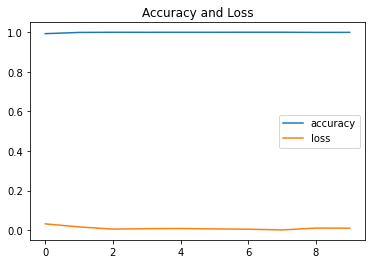

In [ ]:
# 모델 성능 확인
import matplotlib.pyplot as plt
%matplotlib inline

pd.DataFrame(history.history)[['accuracy', 'loss']].plot()
plt.title("Accuracy and Loss")
plt.show()

## 테스트

In [ ]:
# 압축해제 
if not os.path.exists(TEST_PATH + '/crop') : 
  os.mkdir(TEST_PATH + '/crop')

zip_file = ROOT_PATH + '/test_crop.zip'

with zipfile.ZipFile(zip_file) as z:
    z.extractall(TEST_PATH + '/crop')
    
os.remove(zip_file)

In [ ]:
# 테스트 해보기
batch_size = 16
img_height = 26
img_width = 196

test_datagen = ImageDataGenerator(
  rescale = 1./ 255,
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    batch_size=batch_size,
    target_size=(img_height, img_width),
    class_mode='categorical',
    shuffle=False
)

Found 3182 images belonging to 1 classes.


In [ ]:
test_generator.classes

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
# 학습된 모델 불러오기
loaded_model = tf.keras.models.load_model(MODEL_PATH + '/[팀] 미니프로젝트3차_1반_03조_crop.h5')

# 불러온 모델로 예측하기
pred = loaded_model.predict(test_generator)
y_pred = pred.argmax(axis=1)

In [ ]:
np.unique(y_pred)

array([0, 1, 2, 3, 4])

In [ ]:
import re
second = []
filename = test_generator.filenames
for f in filename:
  second.append(int(re.sub(r'[^0-9]', '', f)))

In [ ]:
predict_df = pd.DataFrame({'time' : second, 'class' : y_pred})
predict_df['class'] = predict_df['class'].map({0 : 'boss',
                                                1 : 'chrous',
                                                2 : 'discussion',
                                                3 : 'enter',
                                                4 : 'opening_ending'})

In [ ]:
predict_df = predict_df.sort_values('time', ignore_index=True)

In [ ]:
predict_df

,time,class
0,0,opening_ending
1,1,opening_ending
2,2,opening_ending
3,3,opening_ending
4,4,opening_ending
...,...,...
3177,3177,opening_ending
3178,3178,opening_ending
3179,3179,opening_ending
3180,3180,opening_ending


In [ ]:
predict_df.to_csv(ROOT_PATH + '/전처리1_crop_predict_result.csv')